In [1]:
import serial

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import signal

from utils.QRS_util import *

In [2]:
fs = 1000
nseg = 256
amp = 2 * np.sqrt(2)

def remove_outliers(data):
    q_25 = np.quantile(data, 0.25)
    q_75 = np.quantile(data, 0.75)
    q_50 = np.quantile(data, 0.5)
    upper_limit = q_50 + 10 * (q_75 - q_25)
    lower_limit = q_50 - 10 * (q_75 - q_25)
    data = np.where(data < upper_limit, data, q_50)
    data = np.where(data > lower_limit, data, q_50)
    return data

def normalize(data):
    return (data - data.mean()) / (data.std() + 0.000000001)

def process_ecg(data, plot = False):
    data = remove_outliers(data)
    
    data = normalize(data)
    signal_min = data.min()
    signal_max = data.max()
    
    f, t, Zxx = signal.stft(data, fs, nperseg = nseg)
    Zxx_new = Zxx.copy()
    Zxx_new[25:, :] = 0
    
    _, new_data = signal.istft(Zxx_new, fs)
    new_data = np.where(new_data > signal_min, new_data, signal_min)
    new_data = np.where(new_data < signal_max, new_data, signal_max)
    new_data = normalize(new_data)
    new_data = np.where(new_data < 0, - new_data ** 2, new_data ** 3)
    new_data = normalize(new_data) * 25
    
    if(plot == True):
        fig, ax = plt.subplots(2, 1, figsize = (20, 15), sharex = True)
        ax[0].plot(data)
        ax[0].set_title("Original Signal", fontsize = 20)
        ax[1].plot(new_data)
        ax[1].set_xticks(np.arange(0, data.shape[0] // fs * fs + 1, fs))
        ax[1].set_xticklabels([str(x) for x in np.arange(0, data.shape[0] // fs + 1)])
        ax[1].set_xlabel("Time (s)", fontsize = 15)
        ax[1].set_title("Processed Signal", fontsize = 20)
        plt.show()
    
    return new_data

In [3]:
serialPort = serial.Serial(
    port = "COM3",
    baudrate = 115200,
    bytesize = 8,
    timeout = 2,
    stopbits = serial.STOPBITS_ONE
)

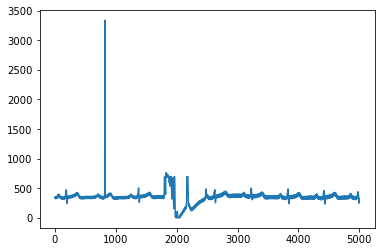

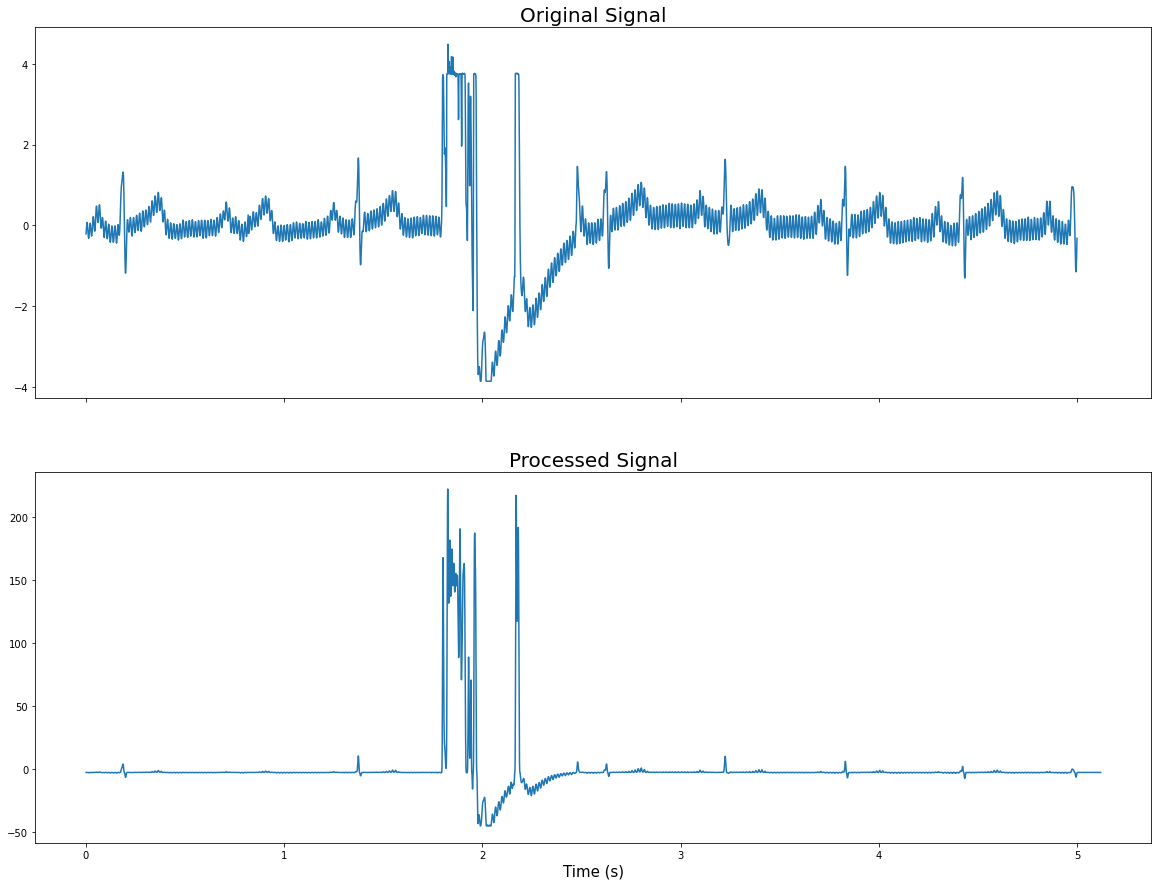

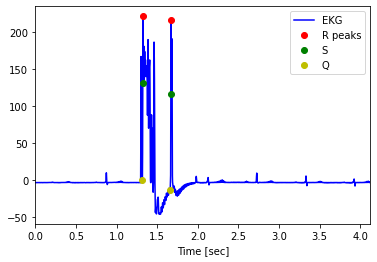

BPM: 29.1


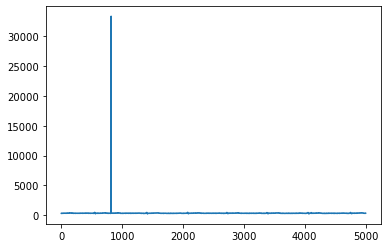

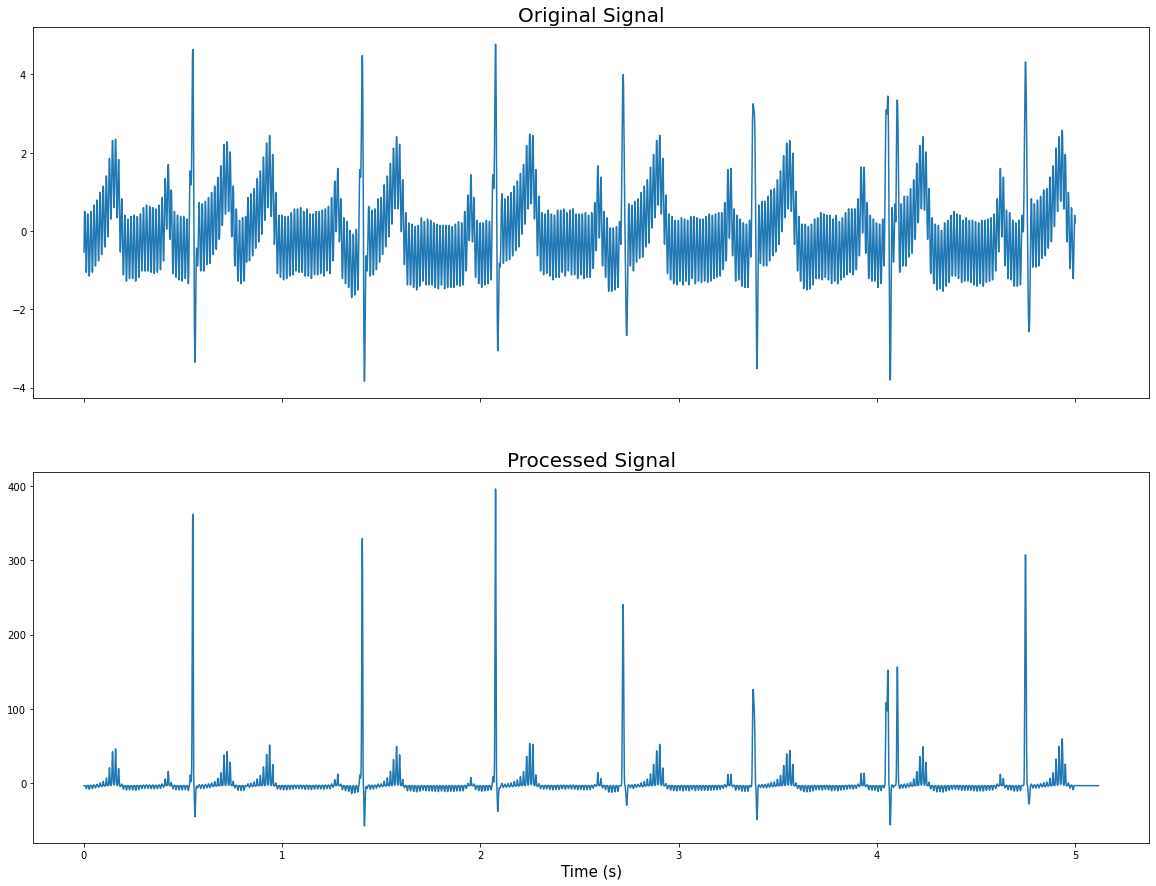

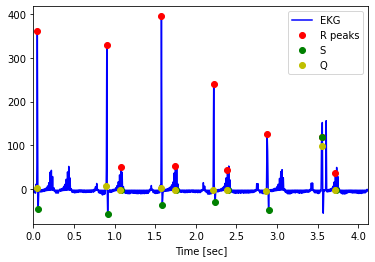

BPM: 145.6


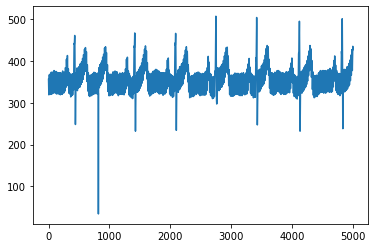

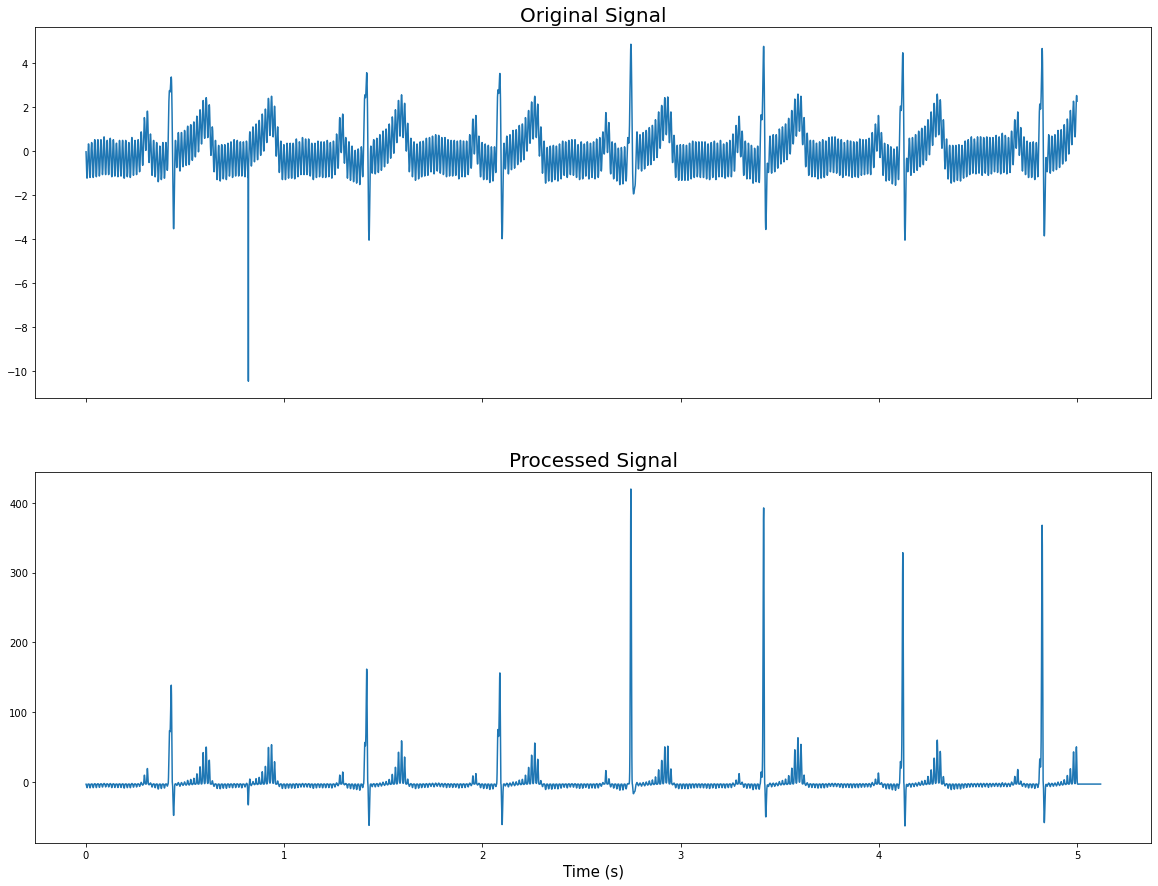

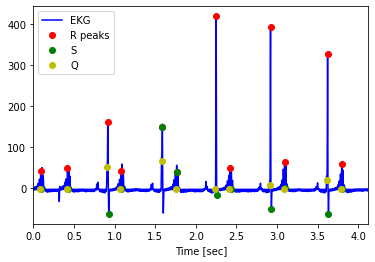

BPM: 174.8


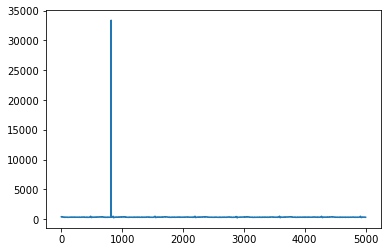

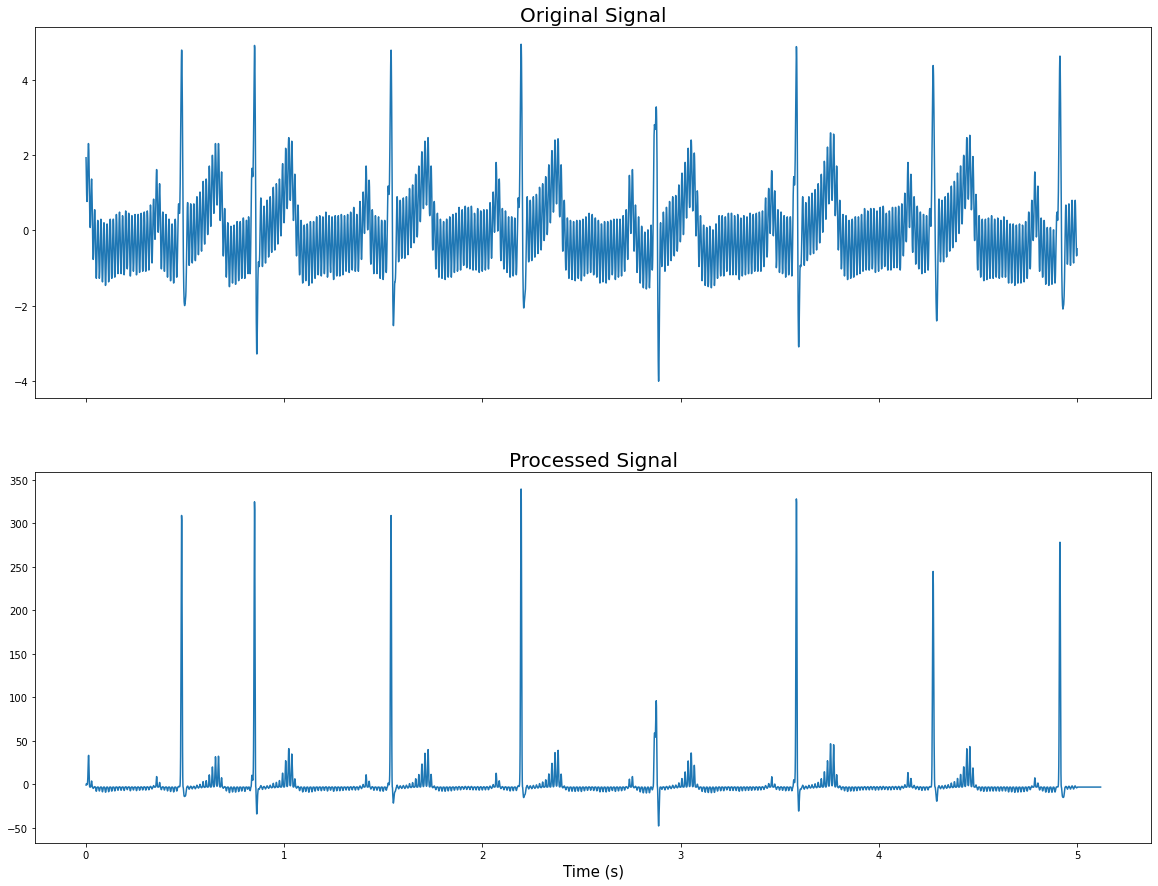

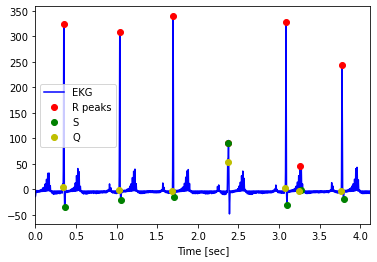

BPM: 101.9


KeyboardInterrupt: 

In [4]:
values = []

serialString = ""                           # Used to hold data coming over UART

while(1):

    # Wait until there is data waiting in the serial buffer
    if(serialPort.in_waiting > 0):

        # Read data out of the buffer until a carraige return / new line is found
        serialString = serialPort.readline()

        # Print the contents of the serial data
        val_str = serialString.decode('Ascii').strip()
        try:
            values.append(int(val_str))
        except:
            pass
        
        if(len(values) > 5000):
            data = np.asarray(values)
            plt.plot(data)
            plt.show()
            new_data = process_ecg(data, plot = True)
            new_data = new_data[500:-500]
            R_peaks, S_pint, Q_point = EKG_QRS_detect(new_data, fs, True, True, factor = 3)
            bpm = len(R_peaks) / (new_data.shape[0] / fs) * 60
            print(f"BPM: {bpm:.1f}")
            
            values = []

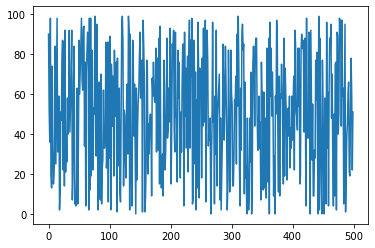

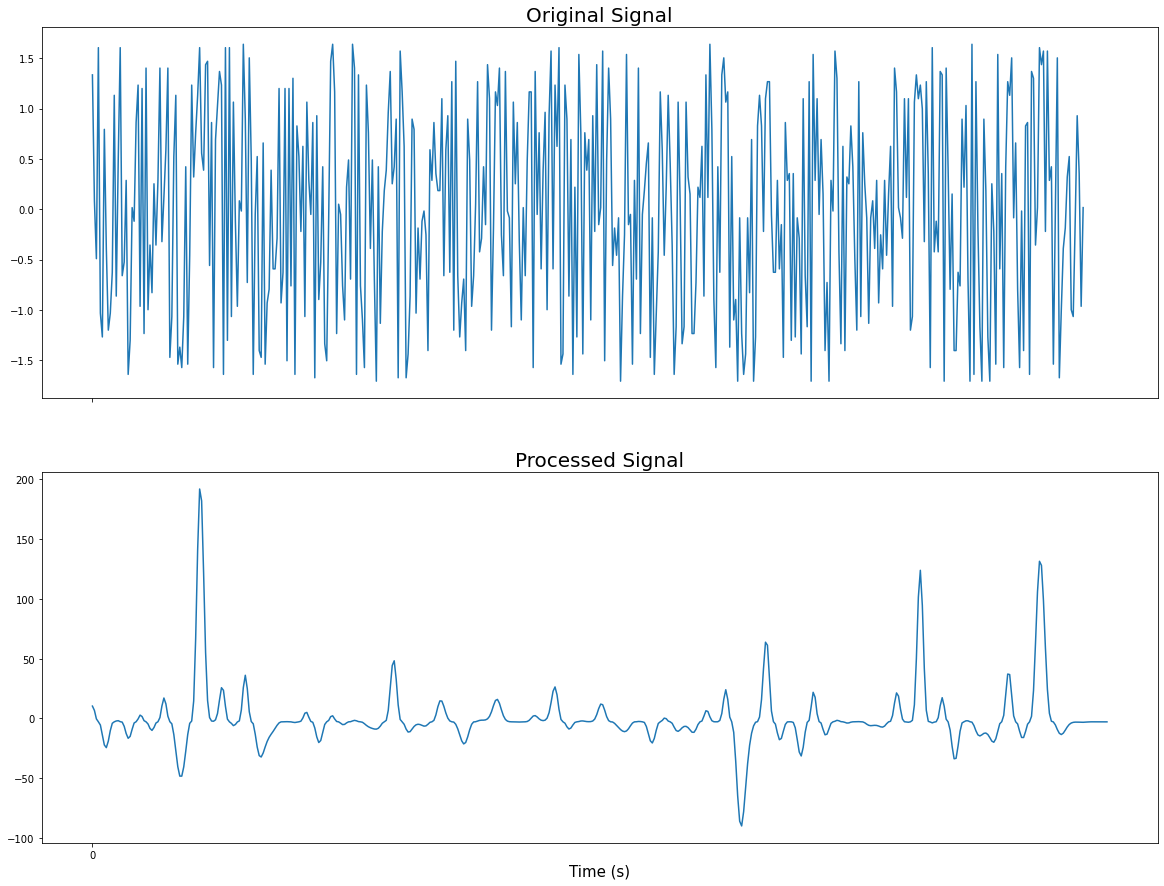

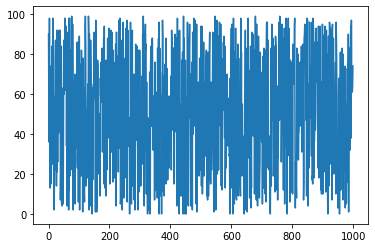

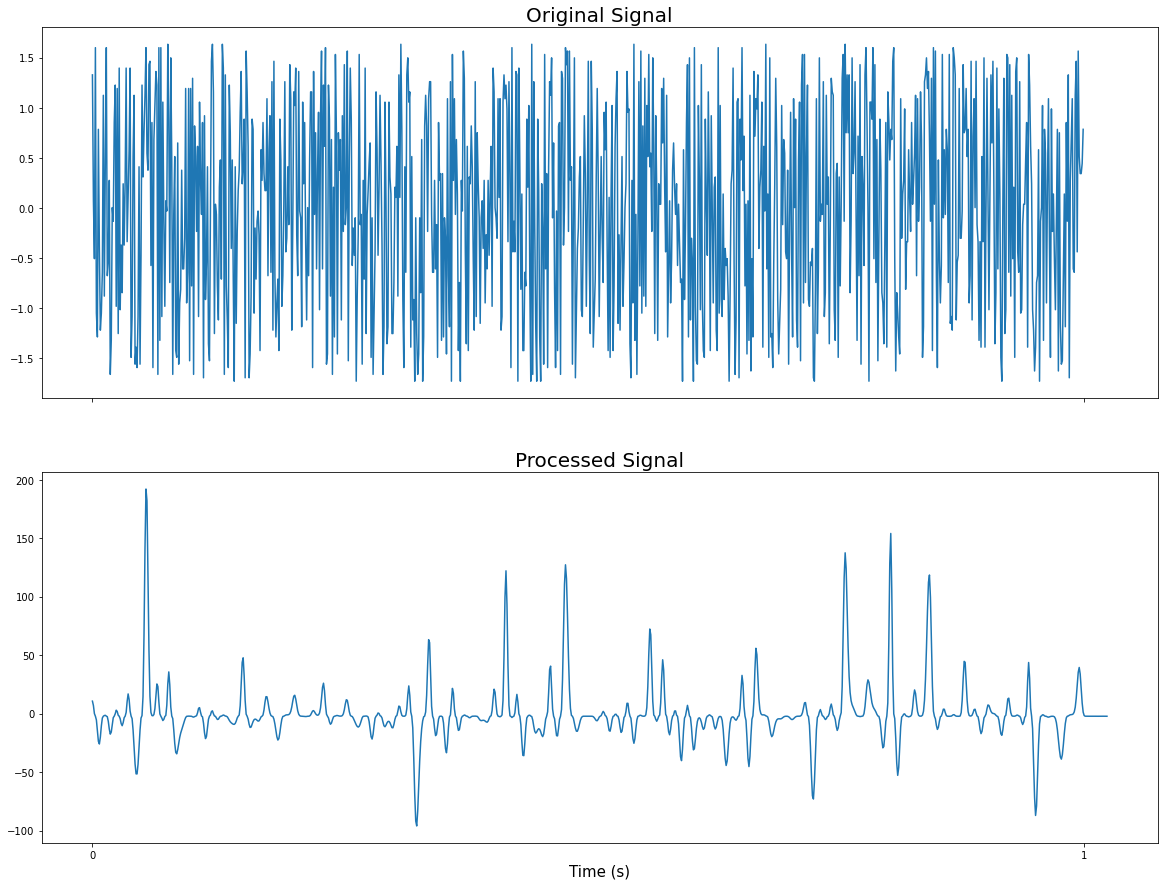

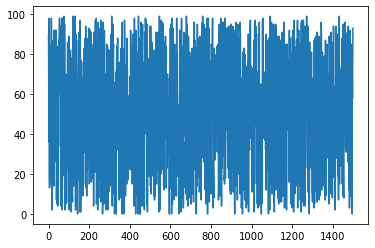

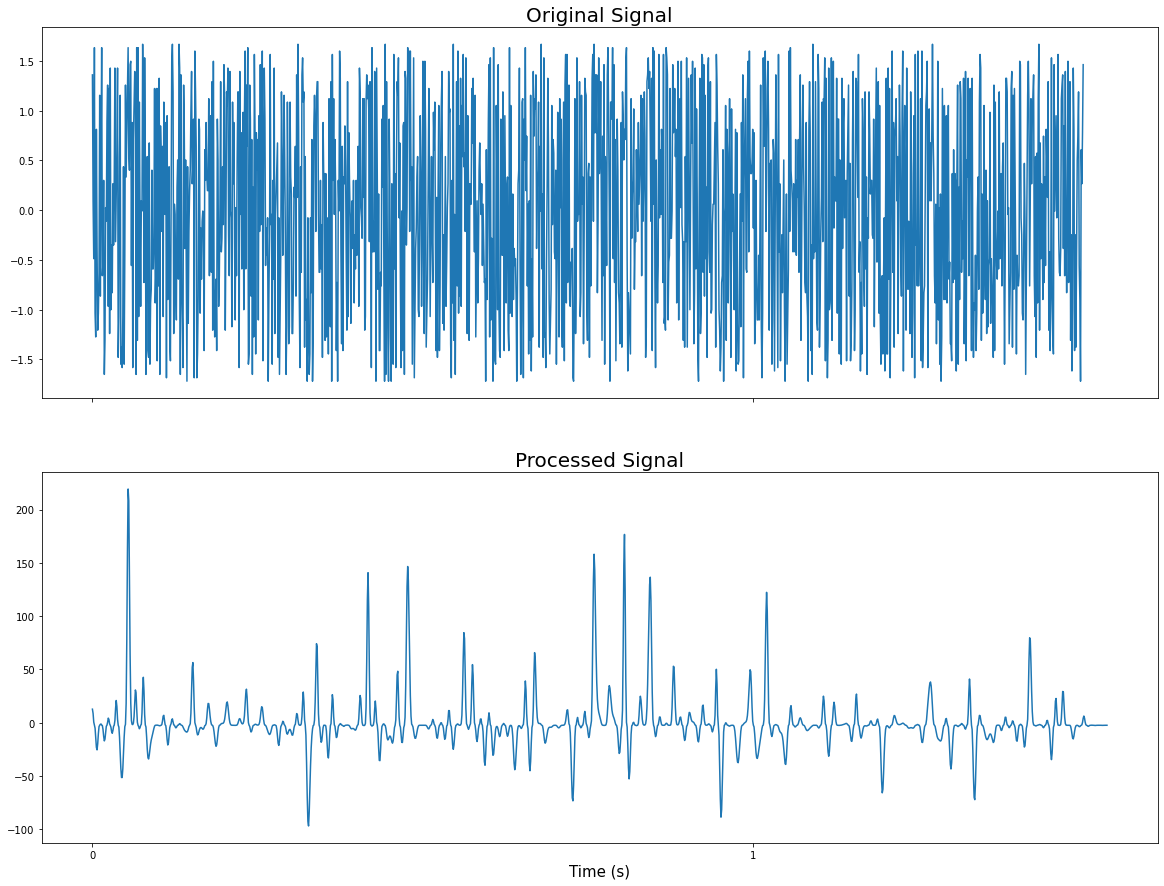

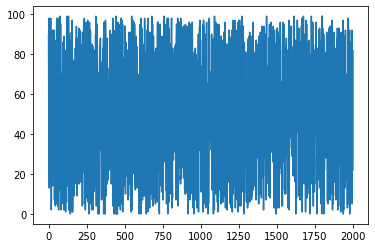

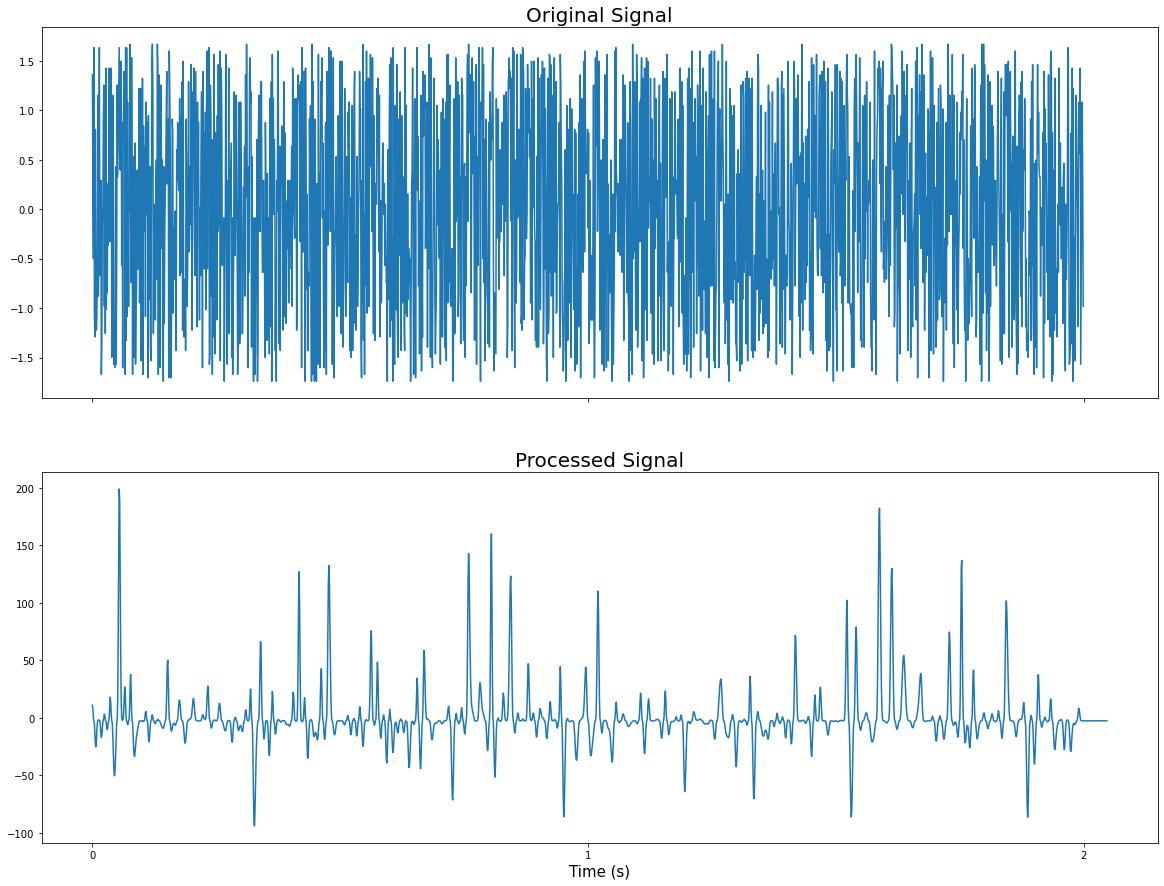

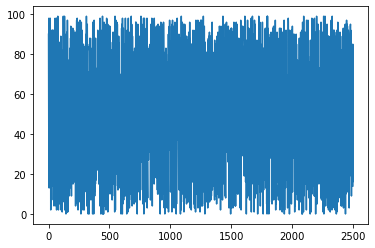

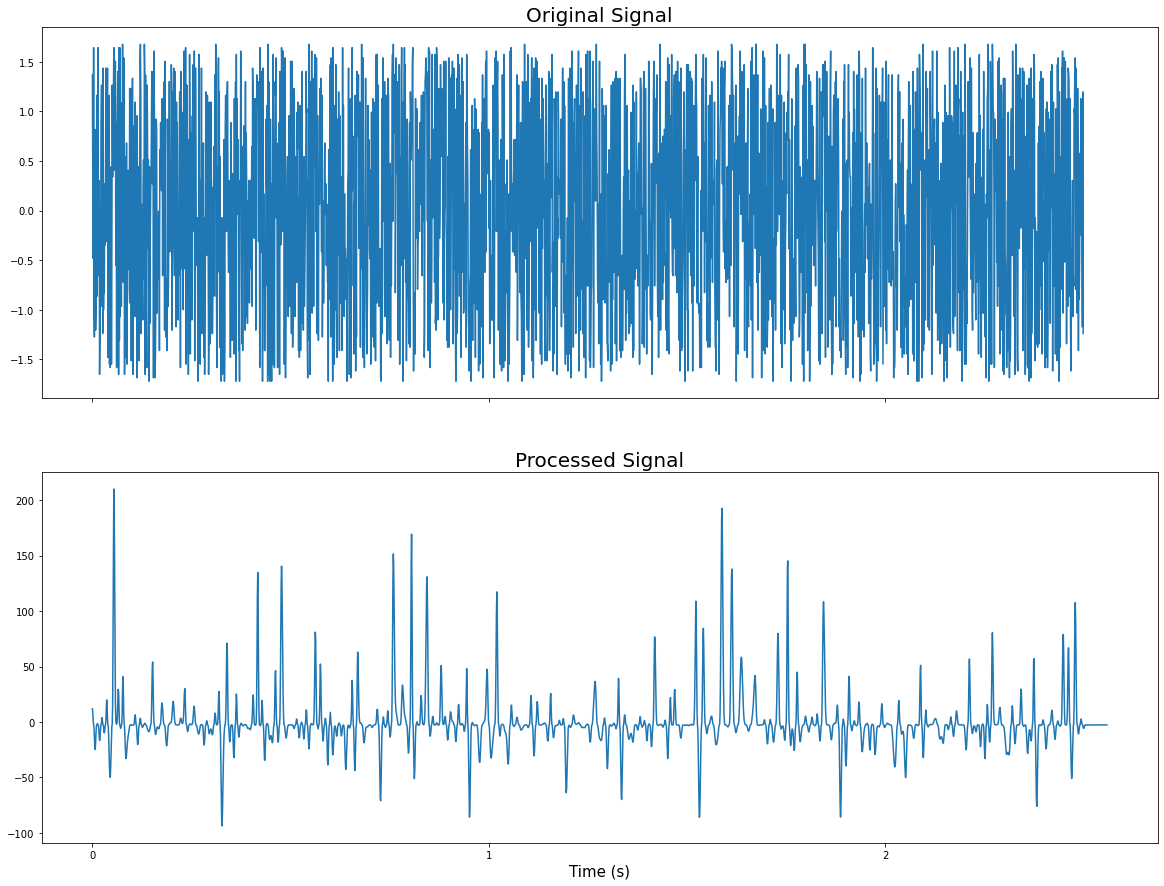

In [7]:
cnt = 0
values = []
while(cnt < 5):
    values.extend(np.random.randint(100, size = 500))
    data = np.asarray(values)
    plt.plot(data)
    plt.show()
    new_data = process_ecg(data, plot = True)
    new_data = new_data[500:-500]
    #R_peaks, S_pint, Q_point = EKG_QRS_detect(new_data, fs, True, True, factor = 3)
    #bpm = len(R_peaks) / (new_data.shape[0] / fs) * 60
    #print(f"BPM: {bpm:.1f}")
    cnt += 1